In [80]:
import numpy as np
import pandas as pd
import mapply
import torch
import open_clip
from torchvision.datasets.folder import default_loader
from torch.utils.data import DataLoader
import wn
from tqdm import tqdm, trange
from IPython.display import Image, display
import matplotlib.pyplot as plt

In [81]:
mapply.init(n_workers=20)
_ = torch.set_grad_enabled(False)
torch.multiprocessing.set_sharing_strategy('file_system')

## Load geo-yfcc dataset with recovered labels and continent grouping

In [82]:
geoyfcc_metadata = pd.read_pickle('/juice2/u/nlp/data/geo_yfcc/recovered_geoyfcc.pkl')
print(geoyfcc_metadata.columns)
print(len(geoyfcc_metadata))

Index(['yfcc_row_id', 'label_ids', 'country', 'country_id', 'in_5k_label_ids',
       'is_train', 'yfcc_metadata', 'file_name', 'label_count',
       'recovered_label', 'continent', 'region'],
      dtype='object')
1146768


In [83]:
country_list = geoyfcc_metadata['country'].unique()
print(len(country_list))
print(country_list)
print(geoyfcc_metadata['country'].value_counts())

62
['Bulgaria' 'Croatia' 'Switzerland' 'Israel' 'Netherlands' 'Malaysia'
 'South Africa' 'China' 'India' 'Egypt' 'Indonesia' 'Ukraine' 'Italy'
 'Turkey' 'Sweden' 'Ireland' 'Australia' 'Costa Rica' 'New Zealand'
 'Jordan' 'United Kingdom' 'The Bahamas' 'Germany' 'Chile' 'Canada'
 'Iceland' 'Thailand' 'Kenya' 'Panama' 'Singapore' 'Greece' 'Philippines'
 'Finland' 'Argentina' 'United States' 'Poland' 'Czech Republic'
 'South Korea' 'Belgium' 'Tanzania' 'France' 'Taiwan' 'Norway' 'Spain'
 'Austria' 'Vietnam' 'Cuba' 'Mexico' 'Hong Kong' 'Brazil' 'Russia'
 'Colombia' 'Cambodia' 'United Arab Emirates' 'Morocco' 'Japan' 'Denmark'
 'Hungary' 'Peru' 'Nepal' 'Romania' 'Portugal']
Chile                   19883
Colombia                19854
Singapore               19847
Peru                    19791
Indonesia               19780
                        ...  
Kenya                   13719
Nepal                   10399
Bulgaria                10395
United Arab Emirates     9995
The Bahamas           

In [84]:
geoyfcc_metadata['continent'].value_counts(normalize = True)

Europe           0.411373
Asia             0.289374
South America    0.116027
Africa           0.077020
North America    0.072706
Oceania          0.033500
Name: continent, dtype: float64

## Load lemma information for all imagenet-21k classes

In [6]:
imagenet21k_metadata = pd.read_csv('/juice2/u/nlp/data/geo_yfcc/imagenet21k_wordnet_ids.txt', sep='\t', header=None, names=['wnid'])
en = wn.Wordnet('omw-en')

In [7]:
imagenet21k_metadata['lemmas'] = imagenet21k_metadata.mapply(lambda row: en.synset(f'omw-en-{row.wnid[1:]}-n').lemmas(), axis='columns')
imagenet21k_metadata['definition'] = imagenet21k_metadata.mapply(lambda row: en.synset(f'omw-en-{row.wnid[1:]}-n').definition(), axis='columns')

  0%|                                                                                                         …

  0%|                                                                                                         …

## Load selected samples with 350 classes (max 2000 samples per class)

In [86]:
preds = np.array(geoyfcc_metadata['recovered_label'])
continent = np.array(geoyfcc_metadata['continent'])
selected = np.load("/juice2/u/nlp/data/geo_yfcc/selected_indices.npy")

In [87]:
print(f"Size: {len(selected)}")
class_count = geoyfcc_metadata['recovered_label'].iloc[selected].value_counts()
print(f"Number of classes: {len(class_count)}")
group_count = geoyfcc_metadata['continent'].iloc[selected].value_counts(normalize = True)
group_dict = list(group_count.index)
print(group_count)

Size: 346577
Number of classes: 350
Europe           0.388298
Asia             0.302845
South America    0.119119
Africa           0.101986
North America    0.059164
Oceania          0.028588
Name: continent, dtype: float64


In [88]:
pred_idx, pred_counts = np.unique(preds[selected], return_counts=True)
pred_counts_argsort = np.argsort(pred_counts)
pred_counts_argsort = np.flip(pred_counts_argsort)
pred_idx, pred_counts = pred_idx[pred_counts_argsort], pred_counts[pred_counts_argsort]

In [89]:
group_class_count = np.zeros((6, len(pred_idx))) 
for i in range(len(pred_idx)):
    indices = np.nonzero(preds[selected] == pred_idx[i])[0]
    indices = selected[indices]
    continents, counts = np.unique(continent[indices], return_counts = True)
    # ['Africa' 'Asia' 'Europe' 'North America' 'Oceania' 'South America']
    for g in range(len(group_class_count)):
        if group_dict[g] in continents: 
            count = counts[np.nonzero(continents == group_dict[g])[0].item()]
        else:
            count = 0
        group_class_count[g][i] = count
    distribution = counts / len(indices)
    print(f'Selected {len(indices)} counts of class index {pred_idx[i]}: {imagenet21k_metadata.iloc[pred_idx[i]].lemmas}')
    if np.max(distribution) > 0.8:
        print(f"Biased group: {continents[np.argmax(distribution)]}, {np.max(distribution)}")

Selected 2000 counts of class index 7314: ['graffito', 'graffiti']
Selected 2000 counts of class index 14870: ['ancient']
Selected 2000 counts of class index 6398: ['door']
Selected 2000 counts of class index 14680: ['Korean']
Biased group: Asia, 0.969
Selected 2000 counts of class index 14679: ['Jordanian']
Biased group: Asia, 0.85
Selected 2000 counts of class index 14611: ['Bahamian']
Biased group: North America, 0.8615
Selected 2000 counts of class index 14593: ['Buddhist']
Biased group: Asia, 0.965
Selected 2000 counts of class index 14443: ['wadi']
Selected 2000 counts of class index 3500: ['giraffe', 'camelopard', 'Giraffa camelopardalis']
Biased group: Africa, 0.9055
Selected 2000 counts of class index 8622: ['monastery']
Biased group: Europe, 0.8515
Selected 2000 counts of class index 8653: ['mosque']
Selected 2000 counts of class index 14361: ['plage']
Selected 2000 counts of class index 8705: ['museum']
Selected 2000 counts of class index 3674: ['African elephant', 'Loxodont

Selected 953 counts of class index 4227: ['air terminal', 'airport terminal']
Selected 951 counts of class index 14682: ['Lao', 'Laotian']
Biased group: Asia, 0.9915878023133544
Selected 943 counts of class index 14178: ['resort', 'resort hotel', 'holiday resort']
Selected 942 counts of class index 16430: ['photojournalist']
Selected 938 counts of class index 7946: ['joss house']
Biased group: Asia, 0.9477611940298507
Selected 936 counts of class index 3324: ['hippopotamus', 'hippo', 'river horse', 'Hippopotamus amphibius']
Biased group: Africa, 0.8621794871794872
Selected 933 counts of class index 14312: ['ice field']
Selected 931 counts of class index 17009: ['tagger']
Selected 930 counts of class index 7167: ['garden']
Selected 926 counts of class index 8737: ['national monument']
Selected 924 counts of class index 14574: ['Gadaba']
Biased group: Asia, 0.8722943722943723
Selected 920 counts of class index 826: ['kite']
Selected 918 counts of class index 17063: ['Timorese']
Selected 

Selected 560 counts of class index 10439: ['skywalk']
Selected 559 counts of class index 5064: ['bridge', 'nosepiece']
Selected 557 counts of class index 107: ['surf casting', 'surf fishing']
Selected 554 counts of class index 14612: ['Bahraini', 'Bahreini']
Biased group: Asia, 0.8194945848375451
Selected 553 counts of class index 11221: ['thatch', 'thatched roof']
Selected 552 counts of class index 14387: ['saltpan']
Selected 550 counts of class index 3623: ['baboon']
Biased group: Africa, 0.850909090909091
Selected 549 counts of class index 505: ['skate']
Selected 546 counts of class index 19926: ['palm', 'palm tree']
Selected 545 counts of class index 15: ['rock climbing']
Selected 545 counts of class index 19627: ['tulip']
Selected 545 counts of class index 10367: ['sidewalk', 'pavement']
Selected 542 counts of class index 19954: ['American oil palm', 'Elaeis oleifera']
Biased group: South America, 0.992619926199262
Selected 541 counts of class index 11869: ['windmill']
Biased grou

<BarContainer object of 350 artists>

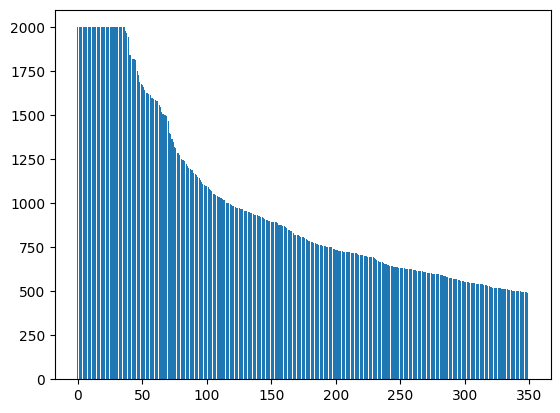

In [90]:
# Element counts of the 350 selected classes (class indexed in order of its size)
plt.bar(np.arange(len(class_count)), class_count.values)

<BarContainer object of 338 artists>

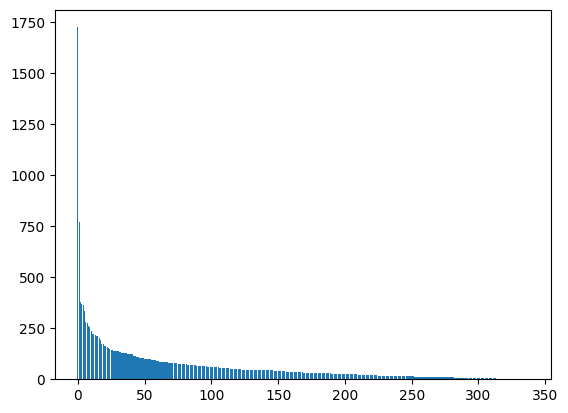

In [91]:
# Class counts of a continent (class indexed in order of its size)
group = 'North America' # ['Africa' 'Asia' 'Europe' 'North America' 'Oceania' 'South America']
indices = selected[np.nonzero(continent[selected] == group)[0]]
class_count_group = geoyfcc_metadata['recovered_label'].iloc[indices].value_counts()
plt.bar(np.arange(len(class_count_group)), class_count_group.values)

In [ ]:
# x = np.arange(len(class_count))
# y1 = group_class_count[0]
# y2 = group_class_count[1]
# y3 = group_class_count[2]
# y4 = group_class_count[3]
# y5 = group_class_count[4]
# y6 = group_class_count[5]
# plt.bar(x, y1, color='r')
# plt.bar(x, y2, bottom=y1, color='b')
# plt.bar(x, y3, bottom=y1+y2, color='m')
# plt.bar(x, y4, bottom=y1+y2+y3, color='c')
# plt.bar(x, y5, bottom=y1+y2+y3+y4, color='g')
# plt.bar(x, y6, bottom=y1+y2+y3+y4+y5, color='y')
# plt.legend(['Europe', 'Asia', 'South America', 'Africa', 'North America', 'Oceania'])

# plt.show()
    

## Look at selections by predicted class

images selected for imagenet-21k class: ['city hall']
country is Denmark


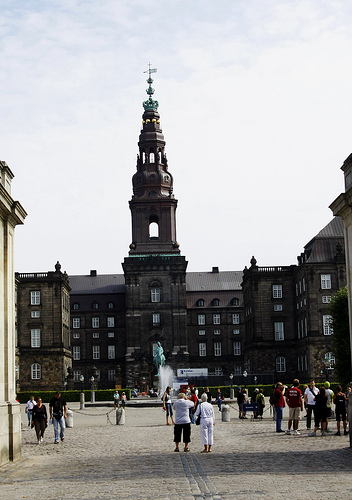

country is Denmark


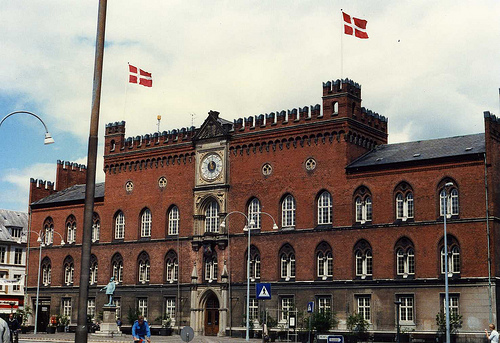

country is Australia


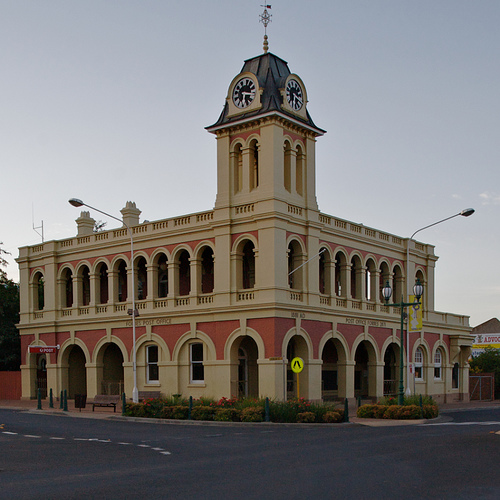

country is South Africa


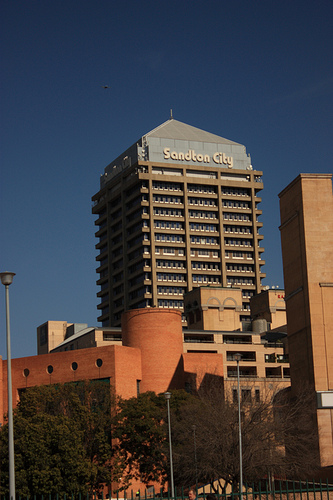

country is France


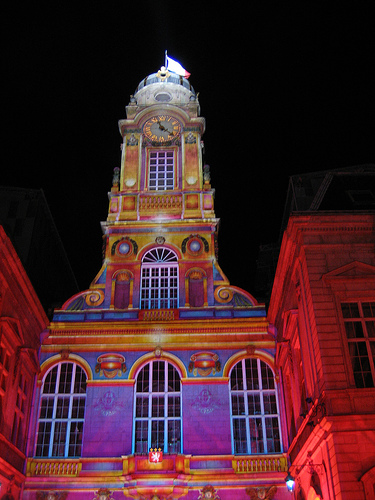

country is Sweden


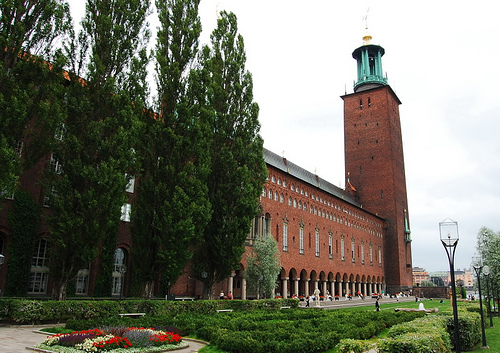

country is France


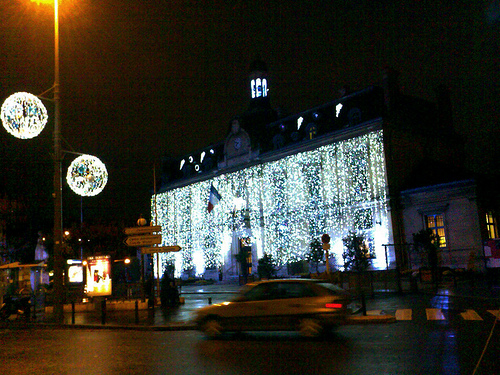

country is Belgium


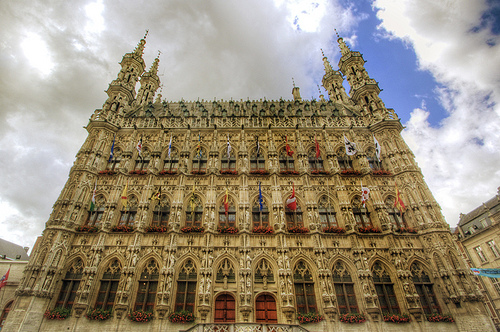

country is Malaysia


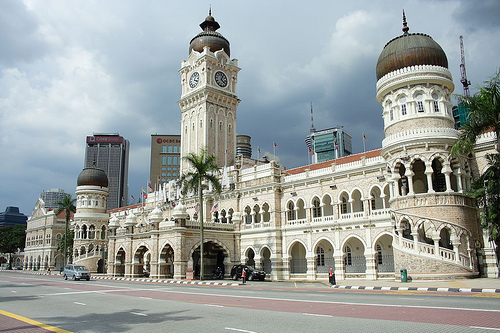

country is Denmark


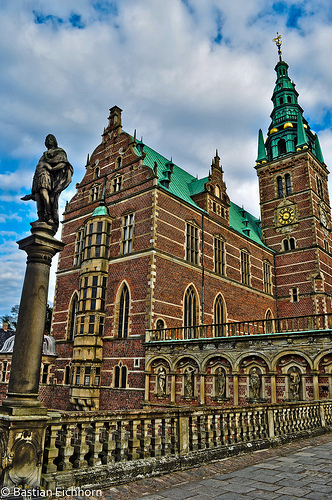

In [19]:
pred_label = 5643
print('images selected for imagenet-21k class:', imagenet21k_metadata.iloc[pred_label].lemmas)
indices = np.nonzero(preds[selected] == pred_label)[0]
pred_label_indices = selected[indices]
shuffle_indices = torch.randperm(len(pred_label_indices))[:10]
for i in pred_label_indices[shuffle_indices]:
    print(f"country is {geoyfcc_metadata.iloc[i.item()]['country']}")
    filename = geoyfcc_metadata.iloc[i.item()]['file_name']
    img_path = '/juice2/u/nlp/data/geo_yfcc/data/' + filename[:3] + '/' + filename + '.jpg'
    display(Image(filename=img_path))

## (No longer needed) Codes for selecting data splits (use the top 1m confident points)

In [168]:
conf_rank = np.load("/juice2/u/nlp/data/geo_yfcc/conf_rank.npy")
confident_points = conf_rank[:1000000]
pred_idx, pred_counts = np.unique(preds[confident_points], return_counts=True)
pred_counts_argsort = np.argsort(pred_counts)
pred_counts_argsort = np.flip(pred_counts_argsort)
pred_idx, pred_counts = pred_idx[pred_counts_argsort], pred_counts[pred_counts_argsort]

In [174]:
threshold = 350
ub = 2000
print(np.sum(pred_counts[:threshold]))
top = np.array(pred_counts[:threshold])
cropped = np.where(top < ub, top, ub)
print(np.sum(cropped))

404662
346577


In [175]:
selected = []
for i in range(350):
    indices = np.nonzero(preds == pred_idx[i])[0]
    indices = np.intersect1d(indices, confident_points)
    if len(indices) > ub: 
        indices = np.random.choice(indices, size = ub, replace = False)
    selected.append(indices)
    print(f"Selected {len(indices)} samples from the class")
    country, distribution = np.unique(continent[indices], return_counts = True)
    # ['Africa' 'Asia' 'Europe' 'North America' 'Oceania' 'South America']
    distribution = distribution / len(indices)
    print(f'clip predicted {pred_counts[i]} counts of class index {pred_idx[i]}: {imagenet21k_metadata.iloc[pred_idx[i]].lemmas}')
    if np.max(distribution) > 0.8:
        print(f"Biased group: {country[np.argmax(distribution)]}, {np.max(distribution)}")
selected = np.concatenate(selected)
print(selected.shape)

Selected 2000 samples from the class
clip predicted 10780 counts of class index 10879: ['street']
Selected 2000 samples from the class
clip predicted 9606 counts of class index 10142: ['sculpture']
Selected 2000 samples from the class
clip predicted 6126 counts of class index 14679: ['Jordanian']
Biased group: Asia, 0.85
Selected 2000 samples from the class
clip predicted 5880 counts of class index 14237: ['beach']
Selected 2000 samples from the class
clip predicted 5749 counts of class index 11179: ['temple']
Biased group: Asia, 0.99
Selected 2000 samples from the class
clip predicted 4891 counts of class index 7314: ['graffito', 'graffiti']
Selected 2000 samples from the class
clip predicted 4734 counts of class index 14106: ['crowd']
Selected 2000 samples from the class
clip predicted 4499 counts of class index 10761: ['statue']
Selected 2000 samples from the class
clip predicted 3843 counts of class index 5454: ['cathedral']
Selected 2000 samples from the class
clip predicted 3766 

Selected 1322 samples from the class
clip predicted 1322 counts of class index 7042: ['fortress', 'fort']
Selected 1316 samples from the class
clip predicted 1316 counts of class index 46: ['surfing', 'surfboarding', 'surfriding']
Selected 1286 samples from the class
clip predicted 1286 counts of class index 14353: ['outcrop', 'outcropping', 'rock outcrop']
Selected 1284 samples from the class
clip predicted 1284 counts of class index 14249: ['caldera']
Selected 1275 samples from the class
clip predicted 1275 counts of class index 10345: ['shrine']
Biased group: Asia, 0.8588235294117647
Selected 1250 samples from the class
clip predicted 1250 counts of class index 14619: ['Carioca']
Biased group: South America, 0.912
Selected 1245 samples from the class
clip predicted 1245 counts of class index 14404: ['sky']
Selected 1244 samples from the class
clip predicted 1244 counts of class index 17186: ['Visayan', 'Bisayan']
Biased group: Asia, 0.9614147909967846
Selected 1239 samples from the 

Selected 904 samples from the class
clip predicted 904 counts of class index 17298: ['parhelion', 'mock sun', 'sundog']
Selected 901 samples from the class
clip predicted 901 counts of class index 11386: ['tower']
Selected 900 samples from the class
clip predicted 900 counts of class index 4746: ['bell tower']
Selected 896 samples from the class
clip predicted 896 counts of class index 9792: ['reservoir']
Selected 893 samples from the class
clip predicted 893 counts of class index 4486: ['backstairs']
Selected 893 samples from the class
clip predicted 893 counts of class index 4536: ['balloon']
Selected 892 samples from the class
clip predicted 892 counts of class index 14408: ['snowfield']
Selected 891 samples from the class
clip predicted 891 counts of class index 11410: ['tramline', 'tramway', 'streetcar track']
Selected 886 samples from the class
clip predicted 886 counts of class index 7739: ['housetop']
Selected 877 samples from the class
clip predicted 877 counts of class index 

Selected 703 samples from the class
clip predicted 703 counts of class index 4197: ['agora', 'public square']
Selected 701 samples from the class
clip predicted 701 counts of class index 3627: ['macaque']
Biased group: Asia, 0.9229671897289586
Selected 698 samples from the class
clip predicted 698 counts of class index 26: ['skiing']
Biased group: Europe, 0.8853868194842407
Selected 697 samples from the class
clip predicted 697 counts of class index 44: ['scuba diving']
Selected 696 samples from the class
clip predicted 696 counts of class index 127: ['American football', 'American football game']
Biased group: Europe, 0.9497126436781609
Selected 695 samples from the class
clip predicted 695 counts of class index 3650: ['spider monkey', 'Ateles geoffroyi']
Biased group: South America, 0.8474820143884892
Selected 693 samples from the class
clip predicted 693 counts of class index 6083: ['cruise ship', 'cruise liner']
Selected 693 samples from the class
clip predicted 693 counts of class

Selected 568 samples from the class
clip predicted 568 counts of class index 9902: ['Roman building']
Selected 568 samples from the class
clip predicted 568 counts of class index 10905: ['student union']
Selected 565 samples from the class
clip predicted 565 counts of class index 14436: ['uphill']
Selected 564 samples from the class
clip predicted 564 counts of class index 15707: ['granddaughter']
Selected 560 samples from the class
clip predicted 560 counts of class index 10439: ['skywalk']
Selected 559 samples from the class
clip predicted 559 counts of class index 5064: ['bridge', 'nosepiece']
Selected 557 samples from the class
clip predicted 557 counts of class index 107: ['surf casting', 'surf fishing']
Selected 554 samples from the class
clip predicted 554 counts of class index 14612: ['Bahraini', 'Bahreini']
Biased group: Asia, 0.8194945848375451
Selected 553 samples from the class
clip predicted 553 counts of class index 11221: ['thatch', 'thatched roof']
Selected 552 samples 

## Look at predictions for randomly sampled images

In [ ]:
for i in np.random.choice(len(geoyfcc_metadata), size=10, replace=False):
    print('clip predicted imagenet-21k class:', imagenet21k_metadata.iloc[preds[i].item()].lemmas)
    filename = geoyfcc_metadata.iloc[i]['file_name']
    img_path = '/juice2/u/nlp/data/geo_yfcc/data/' + filename[:3] + '/' + filename + '.jpg'
    display(Image(filename=img_path))